#### [詳解ディープラーニング　TensorFlow・Kerasによる時系列データ処理](https://book.mynavi.jp/ec/products/detail/id=72995)
　巣籠悠輔 著  
  
support site : [https://book.mynavi.jp/supportsite/detail/9784839962517.html](https://book.mynavi.jp/supportsite/detail/9784839962517.html)  
github : [yusugomori/deeplearning-tensorflow-keras](https://github.com/yusugomori/deeplearning-tensorflow-keras) 


---
## 第５章　リカレントニューラルネットワーク

与えられた時系列データから未来の値ををニューラルネットワークで予測することを考える。

単純な時系列データとして、時刻tの値がf(t)である以下のようなsin波を考える。

\begin{align*}
f(t) &= \sin \left( \frac{2 \pi}{T}t \right) & (t=1,\dots, 2T)
\end{align*}

さらにノイズとして、-1から+1までの値を取る一様分布Uに従う確率変数uの0.05倍を加え、観測値とする。

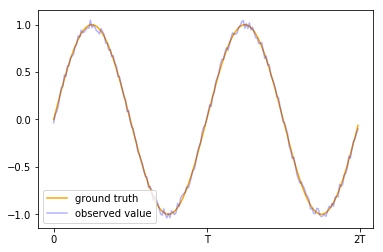

In [13]:
import numpy as np
import matplotlib.pyplot as plt

T = 100
X = np.arange(0, 2*T, 1.)
Y = np.sin(X * np.pi * 2 / T)
Yu = Y + 0.05 * np.random.uniform(-1., 1., X.size)

plt.plot(X, Y, alpha=1.0, color='orange', label='ground truth')
plt.plot(X, Yu, alpha=0.3, color='blue', label='observed value')
plt.xticks([0,T,2*T],["0","T","2T"])
plt.legend()
plt.show()

---
### 過去の状態を保持する隠れ層

時系列データでは各タイムステップのデータに相関があることから  
隠れ層１層を含む３層ニューラルネットワークについて  
前タイムステップにおける隠れ層の情報を隠れ層自身に入力して時系列データに適応させることを考える。  
  
入力層から隠れ層への入力の重みと活性化関数をそれぞれU、f、隠れ層から出力層への重みと活性化関数をV、g、  
隠れ層から隠れ層自身への重みをWとする。  
このとき隠れ層の出力 $h(t)$ は  

\begin{align*}
\mathbf{h}(t) = f(U\mathbf{x}(t) + W\mathbf{h}(t-1) + \mathbf{b})
\end{align*}

出力層の出力 $y(t)$ は

\begin{align*}
y(t) = g(V\mathbf{h}(t) + \mathbf{c})
\end{align*}

と表される。

隠れ層、出力層にて活性化関数へ入力される重み付き和をそれぞれ $\mathbf{p}(t), \mathbf{q}(t)$ とする。

\begin{align*}
\mathbf{p}(t) :=& U\mathbf{x}(t) + W\mathbf{h}(t-1) + \mathbf{b} \\
\mathbf{q}(t) :=& V\mathbf{h}(t) + \mathbf{c}
\end{align*}

このとき、隠れ層および出力層における誤差項

\begin{align*}
\mathbf{e}_{h}(t) :=& \frac{\partial E}{\partial \mathbf{p}(t)} \\
\mathbf{e}_{o}(t) :=& \frac{\partial E}{\partial \mathbf{q}(t)}
\end{align*}

に対して

\begin{align*}
\frac{\partial E}{\partial U} & = \frac{\partial E}{\partial \mathbf{p}(t)} \left( \frac{\partial \mathbf{p}(t)}{\partial U} \right)^{T} & = \mathbf{e}_{h}(t)\mathbf{x}(t)^{T} \\
\frac{\partial E}{\partial V} & = \frac{\partial E}{\partial \mathbf{q}(t)} \left( \frac{\partial \mathbf{q}(t)}{\partial U} \right)^{T} & = \mathbf{e}_{o}(t)\mathbf{h}(t)^{T} \\
\frac{\partial E}{\partial W} & = \frac{\partial E}{\partial \mathbf{p}(t)} \left( \frac{\partial \mathbf{p}(t)}{\partial W} \right)^{T} & = \mathbf{e}_{h}(t)\mathbf{h}(t-1)^{T} \\
\, \\
\frac{\partial E}{\partial \mathbf{b}} & = \frac{\partial E}{\partial \mathbf{p}(t)} \odot \frac{\partial \mathbf{p}(t)}{\partial \mathbf{b}} & = \mathbf{e}_{h}(t) \\
\frac{\partial E}{\partial \mathbf{c}} & = \frac{\partial E}{\partial \mathbf{q}(t)} \odot \frac{\partial \mathbf{q}(t)}{\partial \mathbf{c}} & = \mathbf{e}_{o}(t) 
\end{align*}

となり、隣り合う層から逆伝播する誤差項のみを考えるというアプローチに変化はない。

前のノートブックまでとの違いとして、今回はクラスでなく値を予測するため  
出力層の活性化関数は恒等関数、誤差関数は下記のような二乗誤差（二乗平均誤差）を用いる。  

\begin{align*}
E := \frac{1}{2} \sum_{n=1}^{N} \sum_{t=1}^{T} || \mathbf{t}_{n} - \mathbf{y}_{n} ||^{2}
\end{align*}

---
### BackPropagation Through Time
　参考：  
 - [数式で書き下すリカレントニューラルネットワーク](https://micin.jp/feed/developer/articles/rnn000)  
 - [【前編】深層学習による自然言語処理 - ニューラル機械翻訳への理論 -](http://deeplearning.hatenablog.com/entry/neural_machine_translation_theory)  
 - [Statistical Language Models Based on Neural Networks](http://www.fit.vutbr.cz/~imikolov/rnnlm/google.pdf)   
 - [Recurrent Neural Networks](https://www.slideshare.net/beam2d/pfi-seminar-20141030rnn)  
   

RNNのBackPropagation手法としては BPTT(BackPropagation Through Time) が代表的である。  
これは、上記の誤差逆伝播を時間について展開したとき  
誤差が時間を遡って逆伝播しているように表されることからついた名前である。  
    
ある時間ステップtにおいて、まず１ステップ分だけ過去に遡って逆伝播することを考えると、  
  
\begin{align*}
\mathbf{e}_{h}(t-1) = \frac{\partial E}{\partial \mathbf{p}(t-1)}
\end{align*}

となる。これを変形して

\begin{align*}
\mathbf{e}_{h}(t-1) &= \frac{\partial E}{\partial \mathbf{p}(t)} \odot \frac{\partial \mathbf{p}(t)}{\partial \mathbf{p}(t-1)} \\
&= \mathbf{e}_{h}(t) \odot \left( \frac{\partial \mathbf{p}(t)}{\partial \mathbf{h}(t-1)}\frac{\partial \mathbf{h}(t-1)}{\partial \mathbf{p}(t-1)} \right) \\
&= \mathbf{e}_{h}(t) \odot \left( Wf^{\prime}(\mathbf{p}(t-1)) \right)
\end{align*}

となる。このとこから再帰式は、任意の０または正の整数 $z \, (z=0,1,\dots)$ について

\begin{align*}
\mathbf{e}_{h}(t-z-1) = \mathbf{e}_{h}(t-z) \odot \left( Wf^{\prime}(\mathbf{p}(t-1)) \right)
\end{align*}

と表すことができるので、全ての勾配を計算できる。  
ただし無制限に遡って計算した場合、（上の例のような）RNNにおいては不安定勾配問題を避けられないため、  
遡るステップ数上限を $\tau$ として  

\begin{align*}
U(t+1) &= U(t) - \eta \sum^{\tau}_{z=0} \mathbf{e}_{h}(t-z) \mathbf{x} (t-z)^{T} \\
V(t+1) &= V(t) - \eta \mathbf{e}_{o}(t) \mathbf{h} (t)^{T} \\
W(t+1) &= W(t) - \eta \sum^{\tau}_{z=0} \mathbf{e}_{h}(t-z) \mathbf{x} (t-z-1)^{T} \\
\mathbf{b}(t+1) &= \mathbf{b}(t) - \eta \sum^{\tau}_{z=0} \mathbf{e}_{h}(t-z) \\
\mathbf{c}(t+1) &= \mathbf{c}(t) - \eta \mathbf{e}_{o}(t)
\end{align*}

のように各パラメータの更新式を表し、 $\tau = 10 \sim 100$ とすることが多い。
  
このようにステップ数上限を定めるため、 $\tau$ を超える長期依存 (long-term dependency) を学習できなくなる問題が生じる。  

---
WIP

---
### TensorFlowでの実装
時刻 $1, \ldots, t$ までの観測値が与えられたときに、時刻 $t+1$ での値を予測する課題を解く。  
また $\tau = 25$ として、訓練データセット中の各データは  
$\left( [f(t-\tau), f(t-\tau+1), \ldots, f(t) ], f(t+1) \right)$ という並びの観測値と正解データの組とする。  
  
TensorFlowでは [tf.nn.rnn_cell.BasicRNNCell](https://www.tensorflow.org/api_docs/python/tf/contrib/rnn/BasicRNNCell) として実装されているので、これを利用する。  
  

In [22]:
import numpy as np
from sklearn.model_selection import train_test_split

def toy_problem(x, T=100, ampli=0.05, add_noise=True):
    y = np.sin(x * np.pi * 2 / T)
    yu = y + ampli * np.random.uniform(-1., 1., x.size)
    return  yu if add_noise else y

T = 100
X = np.arange(0, 2*T, 1.)
tau = 25

train_data = []
target_data = []


# dataset
for i in range(T-tau+1):
    train_data.append(toy_problem(X[i:i+tau]).reshape(-1))
    target_data.append(toy_problem(X[i+tau]).reshape(-1))

    X_train, X_test, Y_train, Y_test = train_test_split(train_data, target_data, train_size=0.8, test_size=0.2)    